# **Arabic Handwritten Characters images classification, Using ResNets in PyTorch**
> Training image classifier on single GPU

In [1]:
project_name=' Course-Project-01'


## **Preparing the Arabic Chars Mnist Dataset**


The dataset is composed of 16,800 characters written by 60 participants,The database is partitioned into two sets: a training set (13,440 characters to 480 images per class) and a test set (3,360 characters to 120 images per class) [Arabic-Handwritten-Chars](https://www.kaggle.com/rashwan/arabic-chars-mnist).

In this dataset there are no subfolders for each class (each characters in arabic), so we will built a function, which find the label for each image from image's name. 


In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

### Arabic characters are 28 as shown below:

In [3]:
arabic_labels = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain', 
                'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']

data_dir = '../input/arabic-chars-mnist'

files_train = os.listdir(data_dir+'/train')
files_test = os.listdir(data_dir+'/test')

print("Data: " , os.listdir(data_dir))
print("Number of Classes: " , len(arabic_labels))
print("Labels: " , arabic_labels)
print("training images files: ", files_train[:5])

Data:  ['test', 'train']
Number of Classes:  28
Labels:  ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal', 'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain', 'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']
training images files:  ['alef1792.jpg', 'ain367.jpg', 'beh9646.jpg', 'teh3604.jpg', 'teh10548.jpg']


In [4]:
#function for extract class name from file name
import re
def class_name(fname):
    parts = re.split(r'(\d+)', fname)
    return ' '.join(parts[:-2])

In [5]:
class_name(files_train[8])

'hah'

### **To load the dataset into Dataloader, we used custom dataset class *MyDataset*. (we cant use the ImageFolder class from torchvision without subfolders).** 

In [6]:
class MyDataset(Dataset):
    
    def __init__(self, root_dir, files, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.image_paths = [fname for fname in os.listdir(root_dir) if fname.endswith('.jpg')]
        self.classes = list(set(class_name(fname) for fname in files))
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        
        fname = self.image_paths[index]
        fpath = os.path.join(self.root_dir, fname)
        img = self.transform(Image.open(fpath))
        class_idx = self.classes.index(class_name(fname))
        return img, class_idx   

Create a dataLoader for load batch of images

In [11]:
batch_size = 128
img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transform=tt.Compose([tt.Resize(img_size), 
                      tt.Pad(8, padding_mode='reflect'),
                      tt.RandomCrop(img_size), 
                      tt.ToTensor(), 
                      tt.Normalize(*imagenet_stats)])

In [12]:
#Creating datasets
train_dataset = MyDataset(data_dir+'/train/', files_train, transform=transform)
test_dataset = MyDataset(data_dir+'/test/', files_test, transform=transform)

#Data loaders for training and validation
train_loader = DataLoader(train_dataset , batch_size=batch_size, shuffle=True,
                          num_workers=3, pin_memory=True)
valid_loader = DataLoader(test_dataset, batch_size*2, num_workers=3, pin_memory=True)

Sample of train data set:

In [13]:
image, label = train_dataset[1]
print(image, label)

tensor([[[-0.9534, -0.9534, -0.9534,  ..., -0.9877, -1.0048, -1.0048],
         [-0.9363, -0.9363, -0.9363,  ..., -0.9877, -0.9877, -1.0048],
         [-0.9363, -0.9363, -0.9363,  ..., -0.9877, -0.9877, -1.0048],
         ...,
         [-1.0390, -1.0390, -1.0390,  ..., -0.9705, -0.9534, -0.9534],
         [-1.0390, -1.0390, -1.0390,  ..., -1.0048, -0.9877, -0.9705],
         [-1.0219, -1.0219, -1.0219,  ..., -1.0219, -1.0048, -1.0048]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0182, -2.0182],
         ...,
         [-1.9657, -1.9657, -1.9657,  ..., -2.0182, -2.0182, -2.0182],
         [-1.9832, -1.9832, -1.9832,  ..., -2.0182, -2.0182, -2.0182],
         [-1.9832, -1.9832, -1.9832,  ..., -2.0007, -2.0007, -2.0007]],

        [[-0.2532, -0.2532, -0.2532,  ..., -0.3230, -0.3055, -0.2881],
         [-0.2707, -0.2707, -0.2707,  ..., -0

In [14]:
#shape of images in dataloader
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1,32*32)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 3, 224, 224])
inputs.shape: torch.Size([18816, 1024])


In [15]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):

    print('Label:', train_dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Number of dataset:

In [16]:
len(train_dataset),len(test_dataset)

(13440, 3360)

In [17]:
print(train_dataset.classes)

['reh', 'thal', 'alef', 'zain', 'yeh', 'hah', 'khah', 'jeem', 'noon', 'waw', 'zah', 'sad', 'heh', 'teh', 'seen', 'feh', 'theh', 'qaf', 'tah', 'beh', 'meem', 'ain', 'dad', 'lam', 'dal', 'sheen', 'kaf', 'ghain']


Label: beh (19)


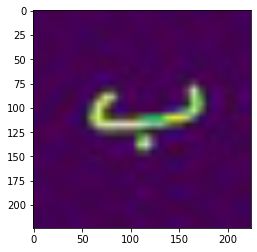

In [18]:
show_image(*train_dataset[2])

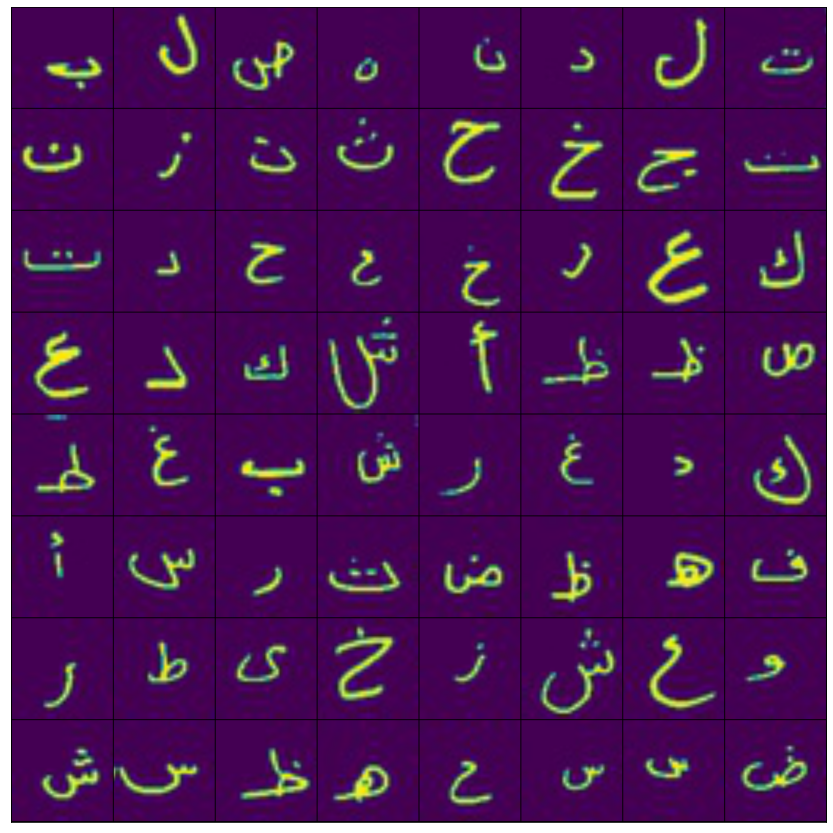

In [19]:
#sample images from the training dataloader.
for images, _ in train_loader:
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_xticks([]); ax.set_yticks([])
    images = denormalize(images[:64], *imagenet_stats)
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

## to train the model faster, Using functions and  **DeviceDataLoader** class to move the model and data to GPU.

In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
device = get_default_device()
device

device(type='cuda')

In [22]:
#Move dataloader to GPU
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(valid_loader, device)

In [23]:
#check if GPU is available
torch.cuda.is_available()

True

use a Pretrained Model (ResNet34) ResNet architecture, Residual Block, after each convolutional layer for normalizing the outputs of the pervious layer we add a batch normalization.


In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 

        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [26]:
from torchvision import models

class ArabicCharsModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [27]:
#move the model to GPU
model = to_device(ArabicCharsModel(len(train_dataset.classes)), device)
model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


ArabicCharsModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

# Training the model

Using techniques to improve the fit function:

* using a learning rate scheduler to generate learning rate for each batch during training. the method used here is "One Cycle Learning Rate Policy".

* regularization technique (weight decay), which adding a term to the loss function to avoid weight overfitting.

* Gradient clipping to avoid gradients value overfitting 


In [29]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [30]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 3.5080246925354004, 'val_acc': 0.0359933041036129}]

In [32]:
#train the model using Adam optimazer
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [33]:
%%time

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00757, train_loss: 0.5256, val_loss: 3.1012, val_acc: 0.5017



Epoch [1], last_lr: 0.00950, train_loss: 0.3536, val_loss: 1.7580, val_acc: 0.7748



Epoch [2], last_lr: 0.00611, train_loss: 0.1652, val_loss: 1.5966, val_acc: 0.8089



Epoch [3], last_lr: 0.00188, train_loss: 0.0989, val_loss: 1.2744, val_acc: 0.9009



Epoch [4], last_lr: 0.00000, train_loss: 0.0508, val_loss: 1.4072, val_acc: 0.9090
CPU times: user 1min 29s, sys: 37.9 s, total: 2min 7s
Wall time: 4min 54s


In [37]:
train_time='4:54'

Plot the improves of valdation set accuracies

In [38]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

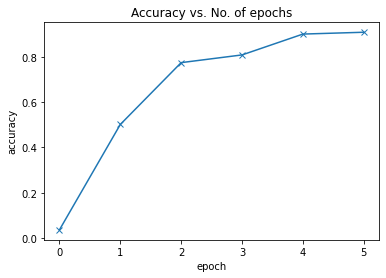

In [39]:
plot_accuracies(history)

Plot the training and validation losses:

In [41]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

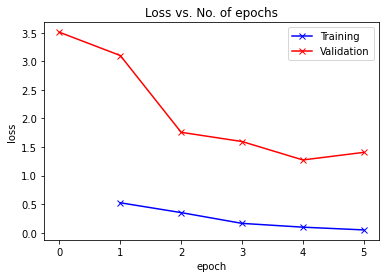

In [42]:
plot_losses(history)

 Plot the changes in learning rate by batch

In [43]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

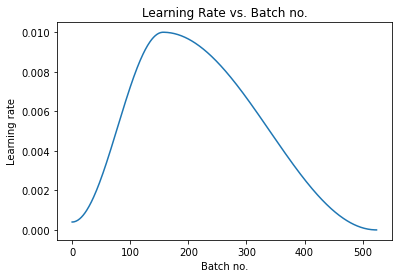

In [44]:
plot_lrs(history)

## Prediction 

Testing with images

In [52]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]

Label: khah , Predicted: khah


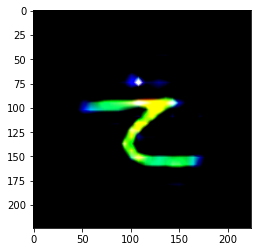

In [55]:
img, label = test_dataset[8]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

# Conclusions
  In this project, used a Pretrained Model (ResNet34) in Pytorch to classify the dataset, which is Arabic characters that contain 28 chars. During the model training we applied strategies in fit function to improves model training and moved the model and data on GPU for faster training, took about (5) minutes to train the model with (90%) accuracy.
 
  Next step, we can apply some techniques like Channel-wise data normalization and Randomized data augmentations while creating the datasets for training and validation to improve the model efficiency.
 

In [57]:
torch.save(model.state_dict(), 'arabicHandwritten-ResNet34.pth')

In [59]:
!pip install jovian --upgrade --quiet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [60]:
import jovian

<IPython.core.display.Javascript object>

In [61]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ········
[jovian] Hyperparams logged.


In [62]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [ ]:
jovian.commit(project=project_name, environment=None, outputs=['arabicHandwritten-resnet9.pth'])


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ai/amjad91-alghamdi/ Course-Project-01


<IPython.core.display.Javascript object>